Content

* Necessary library installation
* Loading Dataset
* Inference on data
* Split train dataset into train, validation and test sets
* Import BERT Model and BERT Tokenizer
* Tokenization
* Tensor Conversion
* DataLoaders Creation
* BERT Model
* Fine tuning,Training and evaluating
* Hyper-Parameter Tuning
  * with learning rate
  * with dropout rate
  * with epochs
* Second Try with inbuilt Trainer

# Install Transformers Library

In [ ]:
# #torch.cuda.is_available()
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install BertTokenizerFast

In [25]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast,get_linear_schedule_with_warmup,BertForSequenceClassification
import time, datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Data/IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.rename(columns = {'sentiment':'label','review':'text'}, inplace = True)
df['label'].value_counts()

label
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
df['label']=df['label'].apply(lambda x: 1 if x=='positive' else 0)
df.head(3)

,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1


<Axes: >

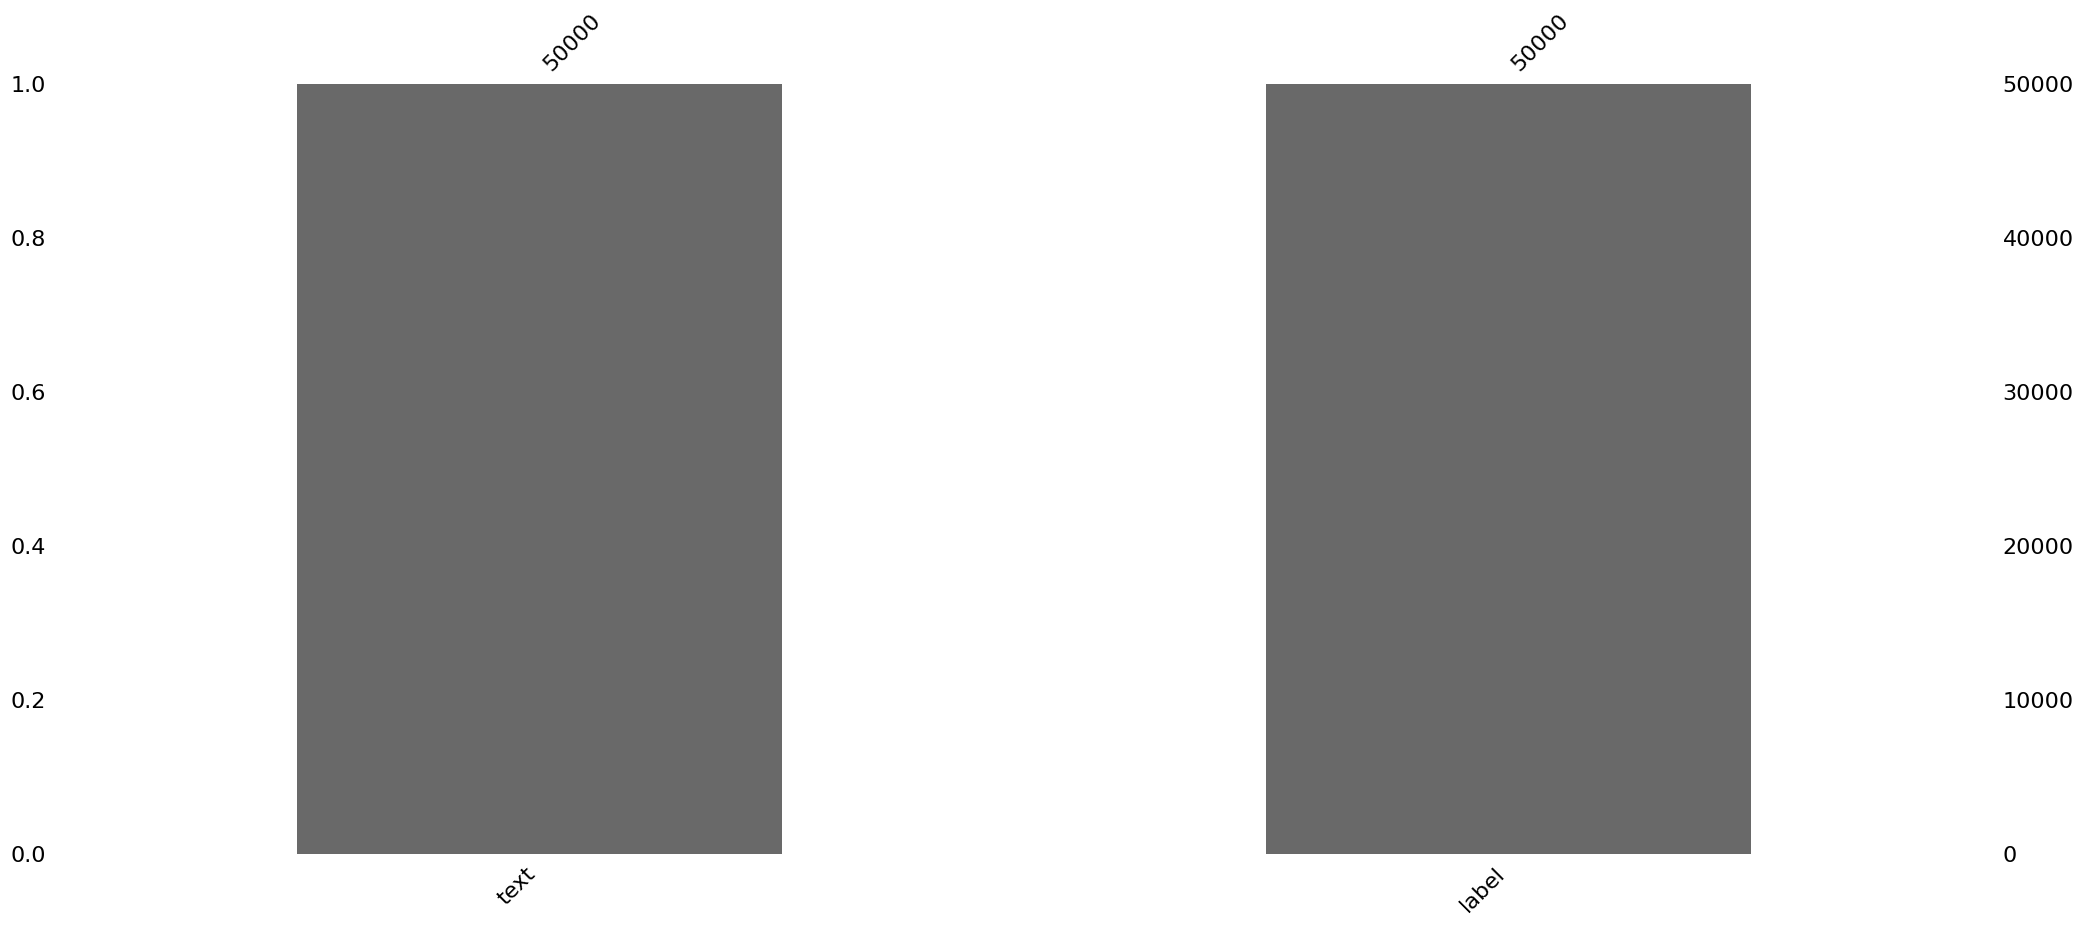

In [ ]:
import missingno as msno
msno.bar(df)

In [ ]:
df.shape

(50000, 2)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

label
1    0.5
0    0.5
Name: proportion, dtype: float64

# Split train dataset into train, validation and test sets



In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased') #bert-base-uncased
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') #bert-base-uncased

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, max_length = 20,truncation=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

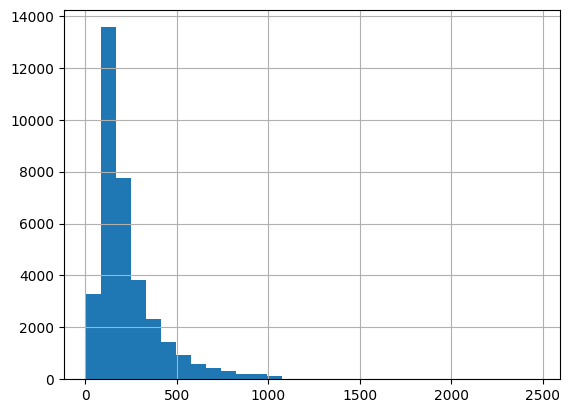

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
max(seq_len)

2470

In [11]:
max_seq_len = 25

In [12]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



# Convert Integer Sequences to Tensors

In [13]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())



# Create DataLoaders

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [15]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [16]:
class BERT_Arch(nn.Module):

    def __init__(self, bert,dropout_rate=0.1):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(dropout_rate)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model
      #print("type",type(sent_id)," ",type(mask))
      #_, cls_hs = self.bert(sent_id, attention_mask=mask)
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [17]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [18]:
# number of training epochs
epochs = 20
total_steps = len(train_text) * epochs

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=0.0001, correct_bias=False)#lr = 1e-3,2e-5)

#Adding Scheduler
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[1. 1.]


In [20]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# Fine-Tune BERT

In [22]:
# function to train the model
def train():
  model.train()
  # empty list to save model predictions
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # add batch to gpu
    # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients
    model.zero_grad()
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    scheduler.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []
  t0 = time.time()
  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    # if step % 50 == 0 and not step == 0:

    #   # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)

      # Report progress.
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
import time, datetime

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20

Evaluating...

Training Loss: 0.663
Validation Loss: 0.634

 Epoch 2 / 20

Evaluating...

Training Loss: 0.636
Validation Loss: 0.623

 Epoch 3 / 20

Evaluating...

Training Loss: 0.624
Validation Loss: 0.615

 Epoch 4 / 20

Evaluating...

Training Loss: 0.621
Validation Loss: 0.611

 Epoch 5 / 20

Evaluating...

Training Loss: 0.618
Validation Loss: 0.614

 Epoch 6 / 20

Evaluating...

Training Loss: 0.617
Validation Loss: 0.609

 Epoch 7 / 20

Evaluating...

Training Loss: 0.612
Validation Loss: 0.619

 Epoch 8 / 20

Evaluating...

Training Loss: 0.613
Validation Loss: 0.608

 Epoch 9 / 20

Evaluating...

Training Loss: 0.611
Validation Loss: 0.633

 Epoch 10 / 20

Evaluating...

Training Loss: 0.610
Validation Loss: 0.600

 Epoch 11 / 20

Evaluating...

Training Loss: 0.608
Validation Loss: 0.603

 Epoch 12 / 20

Evaluating...

Training Loss: 0.607
Validation Loss: 0.598

 Epoch 13 / 20

Evaluating...

Training Loss: 0.607
Validation Loss: 0.599

 Epoch 14 / 20

Eval

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      3750
           1       0.71      0.63      0.66      3750

    accuracy                           0.68      7500
   macro avg       0.68      0.68      0.68      7500
weighted avg       0.68      0.68      0.68      7500



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,2775,975
1,1406,2344


## **Hyperparamter-tuning**

In [28]:
def train(optimizer,model):
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[]
  for step,batch in enumerate(train_dataloader):
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)
  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

def evaluate(model):
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  t0 = time.time()
  for step,batch in enumerate(val_dataloader):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

def run(epochs,optimizer,model):
  best_valid_loss = float('inf')
  train_losses=[]
  valid_losses=[]
  for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train(optimizer,model)
    valid_loss, _ = evaluate(model)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    print(classification_report(test_y, preds))

In [ ]:
#Fine tuning learning rate
print("\n\n-------1e-3 learning rate-------")
optimizer = AdamW(model.parameters(), lr=1e-3, correct_bias=False)
epochs = 5
run(epochs,optimizer,model)

print("\n\n-------2e-5 learning rate-------")
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 5
run(epochs,optimizer,model)

print("\n\n-------0.01 learning rate-------")
optimizer = AdamW(model.parameters(), lr=0.01, correct_bias=False)
epochs = 5
run(epochs,optimizer,model)



-------1e-3 learning rate-------

 Epoch 1 / 5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Evaluating...

Training Loss: 0.637
Validation Loss: 0.612

 Epoch 2 / 5

Evaluating...

Training Loss: 0.624
Validation Loss: 0.606

 Epoch 3 / 5

Evaluating...

Training Loss: 0.622
Validation Loss: 0.604

 Epoch 4 / 5

Evaluating...

Training Loss: 0.618
Validation Loss: 0.601

 Epoch 5 / 5

Evaluating...

Training Loss: 0.616
Validation Loss: 0.599
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      3750
           1       0.66      0.72      0.69      3750

    accuracy                           0.68      7500
   macro avg       0.68      0.68      0.68      7500
weighted avg       0.68      0.68      0.68      7500



-------2e-5 learning rate-------

 Epoch 1 / 5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Evaluating...

Training Loss: 0.609
Validation Loss: 0.596

 Epoch 2 / 5

Evaluating...

Training Loss: 0.610
Validation Loss: 0.596

 Epoch 3 / 5

Evaluating...

Training Loss: 0.608
Validation Loss: 0.596

 Epoch 4 / 5

Evaluating...

Training Loss: 0.609
Validation Loss: 0.596

 Epoch 5 / 5

Evaluating...

Training Loss: 0.610
Validation Loss: 0.596
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      3750
           1       0.67      0.72      0.69      3750

    accuracy                           0.68      7500
   macro avg       0.68      0.68      0.68      7500
weighted avg       0.68      0.68      0.68      7500



-------0.01 learning rate-------

 Epoch 1 / 5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Evaluating...

Training Loss: 0.707
Validation Loss: 0.697

 Epoch 2 / 5

Evaluating...

Training Loss: 0.697
Validation Loss: 0.699

 Epoch 3 / 5

Evaluating...

Training Loss: 0.695
Validation Loss: 0.697

 Epoch 4 / 5

Evaluating...

Training Loss: 0.696
Validation Loss: 0.694

 Epoch 5 / 5

Evaluating...

Training Loss: 0.708
Validation Loss: 0.695
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3750
           1       0.00      0.00      0.00      3750

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Finetuning dropout rate
best_learning_rate = 1e-3

print("\n\n-------0.5 dropout-------")
model = BERT_Arch(bert,0.5)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=best_learning_rate, correct_bias=False)
epochs = 5
run(epochs,optimizer,model)

print("\n\n-------0.8 dropout-------")
model = BERT_Arch(bert,0.8)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=best_learning_rate, correct_bias=False)
epochs = 5
run(epochs,optimizer,model)



-------0.5 dropout-------

 Epoch 1 / 5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Evaluating...

Training Loss: 0.719
Validation Loss: 0.699

 Epoch 2 / 5

Evaluating...

Training Loss: 0.691
Validation Loss: 0.676

 Epoch 3 / 5

Evaluating...

Training Loss: 0.681
Validation Loss: 0.662

 Epoch 4 / 5

Evaluating...

Training Loss: 0.678
Validation Loss: 0.662

 Epoch 5 / 5

Evaluating...

Training Loss: 0.674
Validation Loss: 0.659
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      3750
           1       0.63      0.78      0.70      3750

    accuracy                           0.66      7500
   macro avg       0.67      0.66      0.66      7500
weighted avg       0.67      0.66      0.66      7500



-------0.8 dropout-------

 Epoch 1 / 5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Evaluating...

Training Loss: 0.749
Validation Loss: 0.695

 Epoch 2 / 5

Evaluating...

Training Loss: 0.703
Validation Loss: 0.699

 Epoch 3 / 5

Evaluating...

Training Loss: 0.700
Validation Loss: 0.695

 Epoch 4 / 5

Evaluating...

Training Loss: 0.696
Validation Loss: 0.694

 Epoch 5 / 5

Evaluating...

Training Loss: 0.694
Validation Loss: 0.694
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3750
           1       0.50      1.00      0.67      3750

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#Finetuning epoch
best_learning_rate = 1e-3
best_dropout_rate = 0
model = BERT_Arch(bert,dropout_rate=best_dropout_rate)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=best_learning_rate, correct_bias=False)

print("\n\n-------1 epoch-------")
epochs = 1
run(epochs,optimizer,model)

print("\n\n-------10 epoch-------")
epochs = 10
run(epochs,optimizer,model)

print("\n\n-------50 epoch-------")
epochs = 50
run(epochs,optimizer,model)

# print("\n\n-------100 epoch-------")
# epochs = 100
# run(epochs,optimizer,model)



-------1 epoch-------

 Epoch 1 / 1

Evaluating...

Training Loss: 0.678
Validation Loss: 0.629
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      3750
           1       0.69      0.61      0.65      3750

    accuracy                           0.67      7500
   macro avg       0.67      0.67      0.67      7500
weighted avg       0.67      0.67      0.67      7500



-------10 epoch-------

 Epoch 1 / 10

Evaluating...

Training Loss: 0.628
Validation Loss: 0.619

 Epoch 2 / 10

Evaluating...

Training Loss: 0.622
Validation Loss: 0.624

 Epoch 3 / 10

Evaluating...

Training Loss: 0.621
Validation Loss: 0.615

 Epoch 4 / 10

Evaluating...

Training Loss: 0.616
Validation Loss: 0.604

 Epoch 5 / 10

Evaluating...

Training Loss: 0.612
Validation Loss: 0.603

 Epoch 6 / 10

Evaluating...

Training Loss: 0.611
Validation Loss: 0.603

 Epoch 7 / 10

Evaluating...

Training Loss: 0.607
Validation Loss: 0.632

 Epoch 8 / 10

Evaluatin

KeyboardInterrupt: 

In [30]:
print("\n\n-------100 epoch-------")
epochs = 100
run(epochs,optimizer,model)



-------100 epoch-------

 Epoch 1 / 100

Evaluating...

Training Loss: 0.592
Validation Loss: 0.583

 Epoch 2 / 100

Evaluating...

Training Loss: 0.591
Validation Loss: 0.590

 Epoch 3 / 100

Evaluating...

Training Loss: 0.591
Validation Loss: 0.582

 Epoch 4 / 100

Evaluating...

Training Loss: 0.591
Validation Loss: 0.600

 Epoch 5 / 100

Evaluating...

Training Loss: 0.592
Validation Loss: 0.583

 Epoch 6 / 100

Evaluating...

Training Loss: 0.590
Validation Loss: 0.586

 Epoch 7 / 100

Evaluating...

Training Loss: 0.590
Validation Loss: 0.597

 Epoch 8 / 100

Evaluating...

Training Loss: 0.592
Validation Loss: 0.592

 Epoch 9 / 100

Evaluating...

Training Loss: 0.591
Validation Loss: 0.593

 Epoch 10 / 100

Evaluating...

Training Loss: 0.590
Validation Loss: 0.582

 Epoch 11 / 100

Evaluating...

Training Loss: 0.589
Validation Loss: 0.591

 Epoch 12 / 100

Evaluating...

Training Loss: 0.592
Validation Loss: 0.591

 Epoch 13 / 100

Evaluating...

Training Loss: 0.590
Valid

## **TRY 2 WITH BERT**


In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = model.to(device)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [ ]:
# We already have these train_text,train_labels, val_text, test_text, val_labels, test_labels. So we can use the same

X_train_tokenized = tokenizer(train_text.tolist(), padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(val_text.tolist(), padding=True, truncation=True, max_length=512)


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(X_train_tokenized, train_labels.tolist())
val_dataset = Dataset(X_val_tokenized, val_labels.tolist())

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
#!pip install transformers[torch]

In [ ]:
# Define Trainer
from transformers import TrainingArguments,Trainer

args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss
500,0.396400
1000,0.353400
1500,0.330200
2000,0.292400
2500,0.285900
3000,0.259200
3500,0.255200
4000,0.251400


TrainOutput(global_step=4375, training_loss=0.2973200352260045, metrics={'train_runtime': 3478.0807, 'train_samples_per_second': 10.063, 'train_steps_per_second': 1.258, 'total_flos': 9208886937600000.0, 'train_loss': 0.2973200352260045, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.2222588211297989,
 'eval_accuracy': 0.9362666666666667,
 'eval_precision': 0.9337221633085896,
 'eval_recall': 0.9392,
 'eval_f1': 0.9364530709917575,
 'eval_runtime': 254.3017,
 'eval_samples_per_second': 29.493,
 'eval_steps_per_second': 3.689,
 'epoch': 1.0}

In [ ]:
custom_model = trainer.model.to('cpu')
custom_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# inputs = tokenizer(test_text.tolist(),padding = True, truncation = True, return_tensors='pt').to('cpu')
# outputs = custom_model(**inputs)
# predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

In [ ]:
# # custom_model = trainer.model.to(device)
# # inputs = tokenizer(test_text.tolist(),padding = True, truncation = True, return_tensors='pt')
# # inputs = inputs.to(device)
# input = input.
# custom_model = custom_model.to('cpu')
# outputs = custom_model(inputs)
# predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
# predictions = predictions.numpy()
# #predictions = predictions.cpu().detach().numpy()
# #test_text, test_labels